In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from quspin.tools.evolution import ED_state_vs_time, expm_multiply_parallel

plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.fallback'] = 'stix'
plt.rcParams['font.family'] ='Times New Roman'
plt.style.use('seaborn-v0_8-deep')
prop_cycle = plt.rcParams['axes.prop_cycle']
dcolors = prop_cycle.by_key()['color']

# Model

The O'brian-Fendley model is much like the normal Majorana-Hubbard chain but with a slightly modified interaction term:

\begin{align*}
H_{OF} =& -it\sum_j \gamma_j \gamma_{j+1} -g \sum_j \gamma_{j-2}\gamma_{j-1}\gamma_{j+1}\gamma_{j+2}\\
=& t \sum_j \left(\sigma_j^x +\sigma_j^z \sigma_{j+1}^z\right)
+g \sum_j\left(\sigma_j^x \sigma_{j+1}^x \sigma_{j+2}^z + \sigma_j^z \sigma_{j+1}^z \sigma_{j+2}^z\right)
\end{align*}

In [2]:
def Hof(t, g, basis):
    """
    t, g are couplings
    basis is quspin spinless_fermion_basis_1d
    """
    
    L = basis.N
    
    x_lst = [[-2*t, i] for i in range(L)]
    
    zz_lst = [[-2*t, i, i+1] for i in range(L-1)]
    
    xzz_lst = [[g, i, i+1, i+2] for i in range(L-2)]
    zzx_lst = [[g, i, i+1, i+2] for i in range(L-2)]

    zz_lst += [[-2*t, L-1, 0]]
    
    xzz_lst += [[g, L-2, L-1, 0],
                [g, L-1, 0, 1]]
    
    zzx_lst += [[g, L-2, L-1, 0],
                [g, L-1, 0, 1]]
    
    H = quantum_operator({'static': [['x', x_lst],
                                     ['zz', zz_lst],
                                     ['xzz', xzz_lst],
                                     ['zzx', zzx_lst],
                                    ]}, 
                         basis=basis, check_symm=False, check_herm=False)
    return H

In [3]:
L = 8
basis = spin_basis_1d(L, pauli=1) # pauli matrix, not spin 1/2 (matches iTensor "S=1/2")
t = 1
g = 1
H = Hof(t, g, basis)
e, v = H.eigh()
print(e[:10]) # +L*(t**2+g**2)/g)

[-16.         -16.         -16.         -13.95983604 -13.67676775
 -13.23457504 -13.23457504 -13.06459721 -13.06459721 -12.73913706]


In [4]:
gs = np.linspace(-1, 2, 31)
es = np.zeros((31, 5))
for i, g in enumerate(gs):
    H = Hof(t, g, basis)
    e, v = H.eigh()
    es[i] = e[:5]

Text(0, 0.5, '$E_i-E_0$')

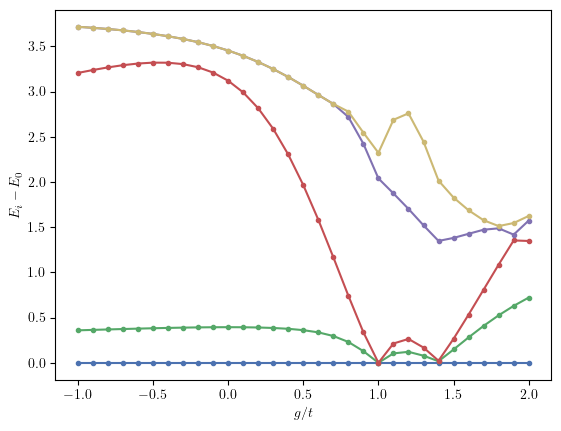

In [5]:
for i in range(5):
    plt.plot(gs, es[:,i]-es[:,0], '.-')
plt.xlabel(r'$g/t$')
plt.ylabel(r'$E_i-E_0$')

# Time evolution

## Case 1: quench, handcoded (ish)

I'm going to start at $g/t=-1$ for $t \leq 0$ and then evolve under the Hamiltonian with $t=0$.

In [6]:
H0 = Hof(1, -1, basis)
Ht = Hof(1, 0, basis)
steps = 11
times = np.linspace(0, 1, steps)
energies = np.zeros(steps)
olaps = np.zeros(steps, dtype=np.complex128)
e, v = H0.eigh()
v0 = v[:,0] # grabbing just the ground state
# Ht_array = Ht.toarray() # converting to dense array for naive exponentiation
et, vt = Ht.eigh()

for i, t in enumerate(times):
    # U = np.exp(-1j*Ht_array*t)
    U = vt @ np.diag(np.exp(-1j*et*t)) @ vt.T
    vi = U.dot(v0)
    vi *= 1./np.linalg.norm(vi)
    olaps[i] = np.vdot(v0, vi)
    energies[i] = Ht.expt_value(vi).real
    print(f"t = {np.round(t, 2)}, e = {energies[i]}, |overlap| = {np.abs(olaps[i])}")

t = 0.0, e = -20.143729044494357, |overlap| = 1.0
t = 0.1, e = -20.14372904449437, |overlap| = 0.9763585011485287
t = 0.2, e = -20.143729044494357, |overlap| = 0.9611192558579789
t = 0.3, e = -20.143729044494375, |overlap| = 0.9859458522481775
t = 0.4, e = -20.14372904449436, |overlap| = 0.9901694886607257
t = 0.5, e = -20.143729044494364, |overlap| = 0.9714456065164089
t = 0.6, e = -20.143729044494354, |overlap| = 0.9740890047125996
t = 0.7, e = -20.143729044494357, |overlap| = 0.9854103931474805
t = 0.8, e = -20.143729044494364, |overlap| = 0.9814464538580792
t = 0.9, e = -20.14372904449436, |overlap| = 0.9736366303404876
t = 1.0, e = -20.14372904449436, |overlap| = 0.9751404970877346


(-21.0, -19.0)

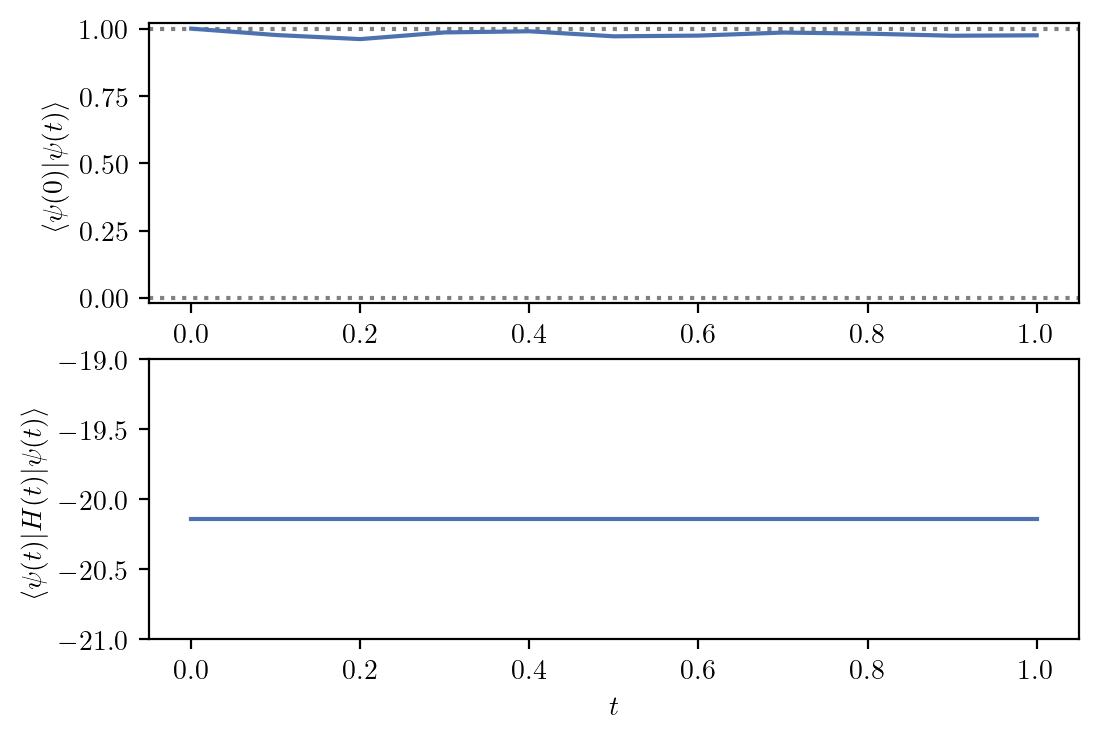

In [7]:
plt.figure(figsize=(6,4), dpi=200)
plt.subplot(2,1,1)
plt.axhline(1, ls=':', color='gray')
plt.axhline(0, ls=':', color='gray')
plt.plot(times, np.abs(olaps))
plt.ylim(-0.02, 1.02)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \psi(0)|\psi(t)\rangle$')

plt.subplot(2,1,2)
plt.plot(times, energies)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \psi(t)|H(t)|\psi(t)\rangle$')
plt.ylim(-21, -19)

## Case 2: using Quspin's built-in time evolution routine
This should be very similar, if not exactly the same.

In [8]:
H0 = Hof(1, -1, basis)
Ht = Hof(1, 0, basis)
steps = 11
times = np.linspace(0, 1, steps)
print(times)

energies = np.zeros(steps)
olaps = np.zeros(steps, dtype=np.complex128)
e, v = H0.eigh()
v0 = v[:,0] # grabbing just the ground state
et, vt = Ht.eigh()

vs = ED_state_vs_time(v0, et, vt, times, iterate=True)

for i, vi in enumerate(vs):
    vi *= 1./np.linalg.norm(vi)
    olaps[i] = np.sqrt(np.vdot(v0, vi)*np.vdot(vi, v0)) # being very explicit, just in case
    energies[i] = Ht.expt_value(vi).real
    print(f"t = {np.round(t, 2)}, e = {energies[i]}, |overlap| = {np.abs(olaps[i])}")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
t = 1.0, e = -20.14372904449436, |overlap| = 1.0
t = 1.0, e = -20.14372904449437, |overlap| = 0.9763585011485286
t = 1.0, e = -20.143729044494354, |overlap| = 0.9611192558579785
t = 1.0, e = -20.14372904449438, |overlap| = 0.9859458522481774
t = 1.0, e = -20.143729044494364, |overlap| = 0.9901694886607258
t = 1.0, e = -20.143729044494364, |overlap| = 0.971445606516409
t = 1.0, e = -20.14372904449436, |overlap| = 0.9740890047125997
t = 1.0, e = -20.143729044494364, |overlap| = 0.9854103931474806
t = 1.0, e = -20.14372904449437, |overlap| = 0.9814464538580793
t = 1.0, e = -20.143729044494357, |overlap| = 0.9736366303404876
t = 1.0, e = -20.143729044494364, |overlap| = 0.9751404970877346


(-21.0, -19.0)

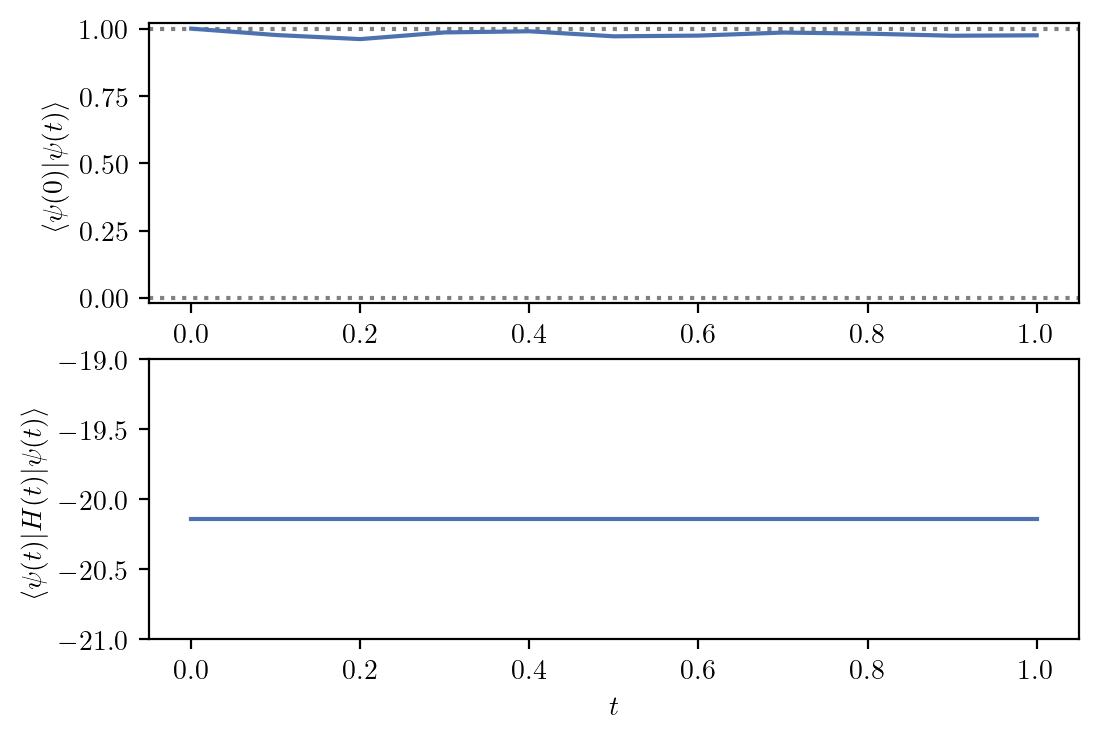

In [9]:
plt.figure(figsize=(6,4), dpi=200)
plt.subplot(2,1,1)
plt.axhline(1, ls=':', color='gray')
plt.axhline(0, ls=':', color='gray')
plt.plot(times, np.abs(olaps))
plt.ylim(-0.02, 1.02)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \psi(0)|\psi(t)\rangle$')

plt.subplot(2,1,2)
plt.plot(times, energies)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \psi(t)|H(t)|\psi(t)\rangle$')
plt.ylim(-21, -19)

## Case 3: sparse exponentiation
The ```expm_multiply_parallel``` produces a function (that can use parallel CPUs) that acts as the exponential of the input matrix for the purposes of computing matrix-vector products without having to store the exponentiated matrix in memory. In the case of a tiny system, it's not really useful, since it's quite a bit slower than the previous routines. This should be more memory efficient for cases where full diagonalization is too hard ($L\gtrapprox 12$).

In [10]:
H0 = Hof(1, -1, basis)
Ht = Hof(1, 0, basis)
Htcsr = Ht.tocsr() # getting Hamiltonian in Compressed Sparse Row format
steps = 11
times = np.linspace(0, 1, steps)
energies = np.zeros(steps)
olaps = np.zeros(steps, dtype=np.complex128)
e, v = H0.eigh()
vi = v[:,0] # grabbing just the ground state
U = expm_multiply_parallel(Htcsr, a=-1j*(times[1]-times[0])) # Propagator for a single timestep
for i, t in enumerate(times):
    # First, compute overlaps and energies
    olaps[i] = np.vdot(v0, vi)
    energies[i] = Ht.expt_value(vi).real
    # Then, evolve state one more time step by multiplying times U
    vi = U.dot(vi)
    vi *= 1./np.linalg.norm(vi) # normalization is Still Important!
    print(f"t = {np.round(t, 2)}, e = {energies[i]}, |overlap| = {np.abs(olaps[i])}")

t = 0.0, e = -20.143729044494357, |overlap| = 1.0000000000000004
t = 0.1, e = -20.143729044494357, |overlap| = 0.9763585011485282
t = 0.2, e = -20.14372904449437, |overlap| = 0.9611192558579787
t = 0.3, e = -20.14372904449438, |overlap| = 0.9859458522481775
t = 0.4, e = -20.14372904449437, |overlap| = 0.9901694886607261
t = 0.5, e = -20.14372904449436, |overlap| = 0.971445606516409
t = 0.6, e = -20.14372904449435, |overlap| = 0.9740890047125994
t = 0.7, e = -20.143729044494368, |overlap| = 0.9854103931474805
t = 0.8, e = -20.143729044494364, |overlap| = 0.9814464538580793
t = 0.9, e = -20.143729044494364, |overlap| = 0.9736366303404872
t = 1.0, e = -20.143729044494354, |overlap| = 0.9751404970877346


(-21.0, -19.0)

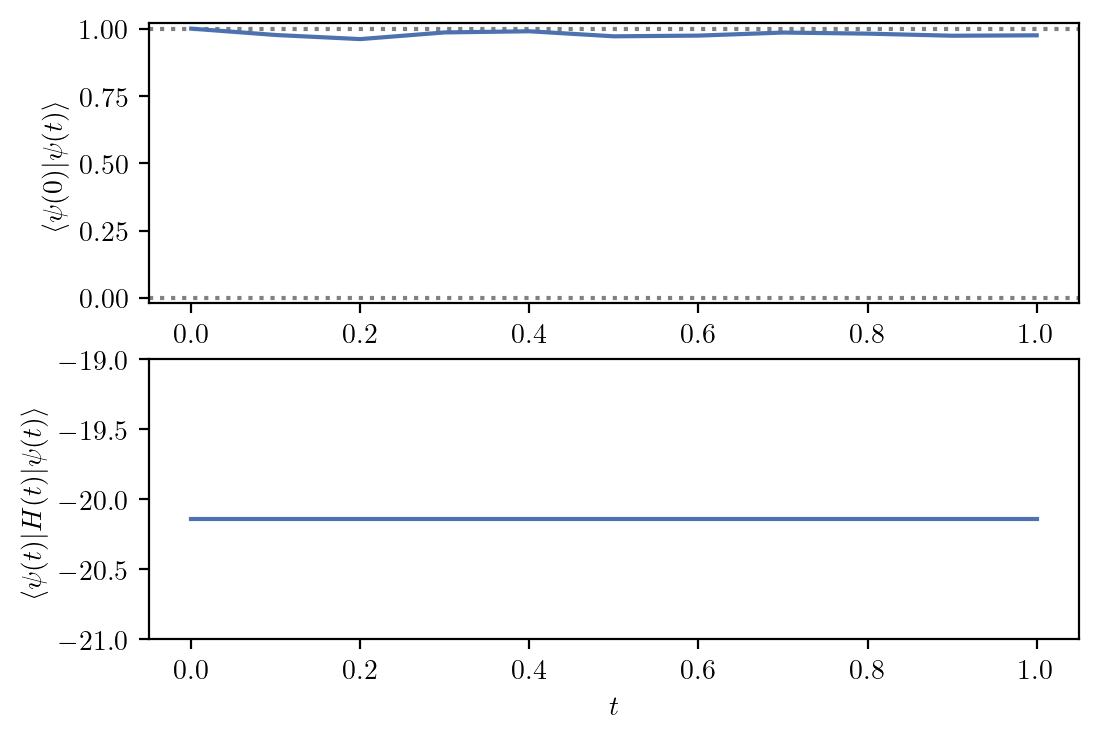

In [11]:
plt.figure(figsize=(6,4), dpi=200)
plt.subplot(2,1,1)
plt.axhline(1, ls=':', color='gray')
plt.axhline(0, ls=':', color='gray')
plt.plot(times, np.abs(olaps))
plt.ylim(-0.02, 1.02)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \psi(0)|\psi(t)\rangle$')

plt.subplot(2,1,2)
plt.plot(times, energies)
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \psi(t)|H(t)|\psi(t)\rangle$')
plt.ylim(-21, -19)